# Ozone
**DATA INFO.** Data frame with measurements of daily ozone concentration on 111 days from May to September 1973 in New York. This data frame is similar to air in S-PLUS (or library(data) in S), but has a different definition for ozone (air contains cube-roots of ozone).

Variables:

|               |                                                       |
|---------------|-------------------------------------------------------|
|ozone          |daily ozone concentration (ppb)                        |
|radiation      |solar radiation (langleys)                             |
|temperature    |daily maximum temperature (degrees F)                  |
|wind           |wind speed (mph)                                       |

In [1]:
import pandas as pd
import numpy as np
from matplotlib import transforms, pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
import itertools

%matplotlib inline

# set up common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
GRAY4 = '#646369'

## Load and Prepare Data

In [2]:
# load and prepare data
df = pd.read_csv("../data/Ozone.txt", sep='\t')
target = 'ozone'
features = ['radiation', 'temperature', 'wind']
X, y = df[features].values, df[target].values
# the target is Cube Root Ozone (cube root ppb)
y = y**(1/3)
df.head()

,ozone,radiation,temperature,wind
0,41.0,190,67,7.4
1,36.0,118,72,8.0
2,12.0,149,74,12.6
3,18.0,313,62,11.5
4,23.0,299,65,8.6


## Local Regression
Scikit-Learn doesn't have local regression implemented. Let's implement it ourselves.

In [3]:
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator

In [4]:
class LocalRegression(BaseEstimator):
    """Local regression model with tri-cube kernel and k-NN bandwidth.
    Parameters
    ----------
        model :
            Underlying model to fit. Should have fit method with weights and
            predict and/or predict_proba methods.
        kernel_size :
            The number or a fraction of nearest points to be in the kernel.
    """
    def __init__(self, model, kernel_size: int=1):
        self.model = model
        self.kernel_size = kernel_size

    def fit(self,
            X: np.ndarray, y: np.array=None) -> 'LocalRegression':
        self.X, self.y = X, y
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict_proba)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.__predict(X, self.model.predict)

    def __predict(self, X: np.ndarray, fnc) -> np.ndarray:
        result = []
        for i in range(X.shape[0]):
            self.model.fit(
                self.X, self.y,
                sample_weight=self.__tri_cube_kernel(X[i:i + 1, :]))
            result.append(np.atleast_2d(fnc([X[i]])))
        return np.vstack(result)

    def __tri_cube_kernel(self, x0):
        points_cnt = self.kernel_size
        if points_cnt <= 1:
            points_cnt = int(self.X.shape[0] * points_cnt)
        distances = cdist(self.X, x0)
        kernel_points_indices = np.argpartition(
            distances, points_cnt, axis=0)[:points_cnt]
        max_distance = np.max(distances[kernel_points_indices])
        relative_distance = distances/max_distance
        result = (relative_distance <= 1)*(1-relative_distance**3)**3
        return np.squeeze(result)

In [5]:
# regresses y on the first column of X and prepares data for plotting
def calc_regression_plot(X, y):
    X = X[:, :1]
    X_min, X_max = np.min(X), np.max(X)
    x_plot = np.linspace(X_min, X_max, 50)
    y_plot = LocalRegression(
        model=LinearRegression(), kernel_size=0.9
    ).fit(X, y).predict(np.atleast_2d(x_plot).T)
    return x_plot, y_plot

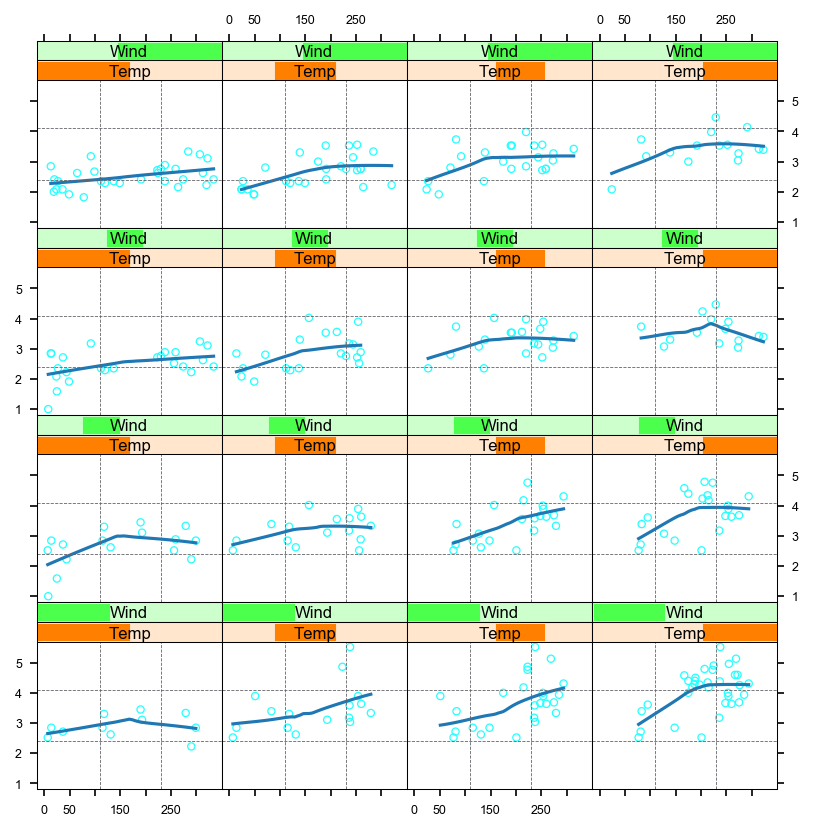

In [6]:
# PAGE 202. FIGURE 6.9. Three-dimensional smoothing example. The response is
#           (cube-root of) ozone concentration, and the three predictors are
#           temperature, wind speed and radiation. The trellis display shows
#           ozone as a function of radiation, conditioned on intervals of
#           temperature and wind speed (indicated by darker green or orange
#           shaded bars). Each panel contains about 40% of the range of each of
#           the conditioned variables. The curve in each panel is a univariate
#           local linear regression, fit to the data in the panel.
temp_min, temp_max = 57, 97
wind_min, wind_max = 2.3, 20.7
temp_bins = [(57, 76.5), (68.2, 81), (76, 86), (80.7, 97)]
wind_bins = [(2.3, 9.25), (6.8, 10.25), (9.15, 12.5), (10.25, 20.7)]

fig, axarr = plt.subplots(4, 4, figsize=(6.37, 6.61), dpi=150)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)

for i, j in itertools.product(range(4), range(4)):
    # find observations that fall into (i, j) bin and run local regression
    temp_from, temp_to, wind_from, wind_to = *temp_bins[j], *wind_bins[3 - i]
    in_temp_bin = (temp_from <= X[:, 1]) & (X[:, 1] <= temp_to)
    in_wind_bin = (wind_from <= X[:, 2]) & (X[:, 2] <= wind_to)
    in_bin = in_temp_bin & in_wind_bin
    X_in_bin, y_in_bin = X[in_bin, :], y[in_bin]
    x_plot, y_plot = calc_regression_plot(X_in_bin, y_in_bin)

    # plot (i, j) subplot
    axarr[i, j].scatter(
        X_in_bin[:, 0], y_in_bin, s=12, facecolors='none',
        edgecolors='#24FFFF', linewidth=0.6)
    axarr[i, j].plot(x_plot, y_plot)
    axarr[i, j].tick_params(
        axis='x', which='both', bottom=(i == 3), top=(i == 0),
        labelbottom=(i == 3 and j % 2 == 0),
        labeltop=(i == 0 and j % 2 == 1))
    axarr[i, j].tick_params(
        axis='y', which='both', right=(j == 3), left=(j == 0),
        labelright=(j == 3 and i % 2 == 0),
        labelleft=(j == 0 and i % 2 == 1))
    plt.setp(
        axarr[i, j],
        xticks=[0, 50, 100, 150, 200, 250, 300],
        xticklabels=['0', '50', '', '150', '', '250', ''],
        yticks=[1, 2, 3, 4, 5],
        yticklabels=[1, 2, 3, 4, 5])
    axarr[i, j].set_ylim(0.8, 7)
    axarr[i, j].set_xlim(-15, 350)
    for l in axarr[i, j].get_yticklabels() + axarr[i, j].get_xticklabels():
        l.set_fontsize(6)
    axarr[i, j].axhline(y=2.4, c=GRAY4, linewidth=0.4, linestyle='--')
    axarr[i, j].axhline(y=4.1, c=GRAY4, linewidth=0.4, linestyle='--')
    axarr[i, j].axvline(x=110, c=GRAY4, linewidth=0.4, linestyle='--')
    axarr[i, j].axvline(x=230, c=GRAY4, linewidth=0.4, linestyle='--')
    rect_wind = Rectangle((-15, 6.35), 365, 0.65, color='#CCFFCC',
                          zorder=10, linewidth=0.5, ec='black')
    rect_temp = Rectangle((-15, 5.70), 365, 0.65, color='#FFE6CC',
                          zorder=10, linewidth=0.5, ec='black')
    axarr[i, j].add_patch(rect_wind)
    axarr[i, j].add_patch(rect_temp)

    rect_wind = Rectangle(
        (-10 + (wind_from - wind_min) * 365 / (wind_max - wind_min), 6.4),
        (wind_to - wind_min) * 365 / (wind_max - wind_min) -
        (wind_from - wind_min) * 365 / (wind_max - wind_min),
        0.5, color='#4DFF4D', zorder=11)
    rect_temp = Rectangle(
        (-10 + (temp_from - temp_min) * 365 / (temp_max - temp_min), 5.75),
        (temp_to - temp_min) * 365 / (temp_max - temp_min) -
        (temp_from - temp_min) * 365 / (temp_max - temp_min),
        0.5, color='#FF8000', zorder=11)
    axarr[i, j].add_patch(rect_wind)
    axarr[i, j].add_patch(rect_temp)
    axarr[i, j].text(130, 6.5, 'Wind', zorder=12, fontsize=8)
    axarr[i, j].text(127, 5.82, 'Temp', zorder=12, fontsize=8)